# Cell 0

In [1]:
# ===== Cell 0 — Imports =====
import os, json, math, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler

from scipy import stats

# Optional: LOWESS trend for scatter (fallbacks if not present)
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    HAVE_LOWESS = True
except Exception:
    HAVE_LOWESS = False

# Optional: solar position (if pvlib available; otherwise GHI threshold is used)
try:
    import pvlib
    HAVE_PVLIB = True
except Exception:
    HAVE_PVLIB = False

plt.rcParams.update({
    "figure.figsize": (7, 5),
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False
})

warnings.filterwarnings("ignore")


In [2]:
# Set your file path here:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass  # not Colab
DATA_PATH = Path("/content/drive/MyDrive/Colab Notebooks/renewables_outputs/merged_by_continent/refined_df.csv")
# read the file and get the columns and head
df = pd.read_csv(DATA_PATH)
display(df.head())
display(df.columns)

Mounted at /content/drive


,site_id,lat,lon,met_ghi,met_dni,met_dhi,met_temp_c,met_pressure_hpa,met_cloud_cover,met_wind_speed_10m,...,ts_utc,ts_local,hour,doy,month,weekday,is_weekend,is_daylight,solar_struct_zero,wind_near_zero
0,AR_ComodoroRivadavia,-45.8641,-67.4805,38.0,6.0,32.0,18.8,994.1,100,28.1,...,2022-01-01 00:00:00+00:00,2022-01-01 01:00:00+01:00,1,1,1,5,True,True,False,True
1,CL_Calama_Antofagasta,-22.4540,-68.9290,6.0,3.0,3.0,20.0,782.1,0,16.4,...,2022-01-01 00:00:00+00:00,2022-01-01 01:00:00+01:00,1,1,1,5,True,True,False,True
2,US_TX_Lubbock,33.5779,-101.8552,22.0,1.0,21.0,12.1,893.7,100,28.0,...,2022-01-01 00:00:00+00:00,2022-01-01 01:00:00+01:00,1,1,1,5,True,True,False,True
3,VN_NinhThuan,11.7167,108.8333,50.0,25.0,25.0,22.6,999.0,77,6.4,...,2022-01-01 00:00:00+00:00,2022-01-01 01:00:00+01:00,1,1,1,5,True,True,False,False
4,FR_SaintNazaire,47.2735,-2.2137,0.0,0.0,0.0,11.1,1022.2,58,17.1,...,2022-01-01 00:00:00+00:00,2022-01-01 01:00:00+01:00,1,1,1,5,True,False,True,True


Index(['site_id', 'lat', 'lon', 'met_ghi', 'met_dni', 'met_dhi', 'met_temp_c',
       'met_pressure_hpa', 'met_cloud_cover', 'met_wind_speed_10m',
       'met_wind_speed_100m', 'target_wind_mw', 'target_solar_mw', 'continent',
       'ts_utc', 'ts_local', 'hour', 'doy', 'month', 'weekday', 'is_weekend',
       'is_daylight', 'solar_struct_zero', 'wind_near_zero'],
      dtype='object')

In [3]:
# ===== Cell 1 — CONFIG & load =====
# Flexible column aliases (edit if schema differs)
ALIASES = {
    "timestamp": ["ts_utc", "timestamp", "time", "date_time", "datetime", "ts"],
    "site": ["site_id", "site", "location", "region", "country"],
    "solar": ["target_solar_mw", "solar_generation", "solar_mw", "pv_power", "solar"],
    "wind":  ["target_wind_mw" , "wind_generation" , "wind_mw" , "wt_power", "wind"],
    "ghi":   ["met_ghi", "ghi", "GHI"],
    "dni":   ["met_dni", "dni", "DNI"],
    "dhi":   ["met_dhi", "dhi", "DHI"],
    "ws10":  ["met_wind_speed_10m", "wind_speed_10m", "ws10"],
    "ws100": ["met_wind_speed_100m","wind_speed_100m","ws100"],
    "cc":    ["met_cloud_cover", "cloudcover", "cloud_cover", "cc"],
    "temp":  ["met_temp_c","temperature","temp_c","t2m"]
}

def resolve_col(df, keys):
    for k in keys:
        if k in df.columns: return k
    return None

df = pd.read_csv(DATA_PATH)
# Parse timestamp
ts_col = resolve_col(df, ALIASES["timestamp"])
if ts_col is None:
    raise ValueError("Timestamp column not found. Update ALIASES.")
df[ts_col] = pd.to_datetime(df[ts_col], utc=True, errors="coerce")
df = df.sort_values(ts_col).reset_index(drop=True)

site_col  = resolve_col(df, ALIASES["site"])
solar_col = resolve_col(df, ALIASES["solar"])
wind_col  = resolve_col(df, ALIASES["wind"])
ghi_col   = resolve_col(df, ALIASES["ghi"])
dni_col   = resolve_col(df, ALIASES["dni"])
dhi_col   = resolve_col(df, ALIASES["dhi"])
ws10_col  = resolve_col(df, ALIASES["ws10"])
ws100_col = resolve_col(df, ALIASES["ws100"])
cc_col    = resolve_col(df, ALIASES["cc"])
temp_col  = resolve_col(df, ALIASES["temp"])

print("Resolved columns:", dict(
    timestamp=ts_col, site=site_col, solar=solar_col, wind=wind_col,
    ghi=ghi_col, dni=dni_col, dhi=dhi_col, ws10=ws10_col, ws100=ws100_col, cc=cc_col, temp=temp_col
))

Resolved columns: {'timestamp': 'ts_utc', 'site': 'site_id', 'solar': 'target_solar_mw', 'wind': 'target_wind_mw', 'ghi': 'met_ghi', 'dni': 'met_dni', 'dhi': 'met_dhi', 'ws10': 'met_wind_speed_10m', 'ws100': 'met_wind_speed_100m', 'cc': 'met_cloud_cover', 'temp': 'met_temp_c'}


In [4]:
# ===== Cell 2 — Masks =====
def daylight_mask(df, ts=ts_col, ghi=ghi_col, lat=None, lon=None, ghi_threshold=5):
    if ghi and ghi in df.columns:
        return (df[ghi].fillna(0) > ghi_threshold).values
    # Optional pvlib-based daylight if GHI missing and coordinates known
    if HAVE_PVLIB and (lat is not None) and (lon is not None):
        times = pd.DatetimeIndex(df[ts])
        solpos = pvlib.solarposition.get_solarposition(times, lat, lon)
        return (solpos['apparent_elevation'] > 0).values
    # Fallback: approximate daylight by hour
    hrs = pd.DatetimeIndex(df[ts]).tz_convert("UTC").hour
    return ((hrs >= 6) & (hrs <= 18)).values

def non_calm_mask(df, ws_col, thresh=0.5):
    if (ws_col is None) or (ws_col not in df.columns):
        return np.ones(len(df), dtype=bool)
    return (df[ws_col].astype(float).fillna(0) >= thresh).values

is_day = daylight_mask(df)
is_windy = non_calm_mask(df, ws100_col or ws10_col)

print(f"Daylight hours: {is_day.sum()} / {len(df)}")
print(f"Non-calm (ws):  {is_windy.sum()} / {len(df)}")


Daylight hours: 1367759 / 2698080
Non-calm (ws):  2696354 / 2698080


In [7]:
# ===== Cell — Table 1 (Descriptives by region/site) =====
from pathlib import Path
import numpy as np
import pandas as pd

OUT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/out"); OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Helper: choose available columns safely ---
def present(*cols):
    return [c for c in cols if c and (c in df.columns)]

# --- Detect a region/continent column if present ---
REGION_CANDIDATES = ["continent", "region", "geo_region", "country_group"]
region_col = next((c for c in REGION_CANDIDATES if c in df.columns), None)

# --- Group keys (region-only and region+site if site exists) ---
group_region = [c for c in [region_col] if c]
group_site   = [c for c in [region_col, site_col] if c]

# --- Aggregation function with nice names (count, mean, std, p25, p50, p75, min, max) ---
def summarize(df_sub, group_cols, cols):
    q25 = lambda x: x.quantile(0.25); q25.__name__ = "p25"
    q50 = lambda x: x.quantile(0.50); q50.__name__ = "p50"
    q75 = lambda x: x.quantile(0.75); q75.__name__ = "p75"
    agg = {c: ["count","mean","std","min",q25,q50,q75,"max"] for c in cols}
    out = df_sub.groupby(group_cols, dropna=False).agg(agg)
    out.columns = [f"{v}_{stat}" for v,stat in out.columns]
    return out.reset_index()

# ---------- SOLAR (daylight) ----------
solar_vars = present(solar_col, ghi_col, dni_col, dhi_col, cc_col, temp_col)
solar_df = df.loc[is_day, present(ts_col, site_col, region_col, *solar_vars)].copy()

tbl1a_region = summarize(solar_df, group_region or [site_col], solar_vars)
tbl1a_site   = summarize(solar_df, group_site or [site_col], solar_vars)

tbl1a_region.to_csv(OUT_DIR / "Table_1a_solar_by_region.csv", index=False)
tbl1a_site.to_csv(OUT_DIR / "Table_1a_solar_by_site.csv", index=False)

print("Saved:",
      OUT_DIR / "Table_1a_solar_by_region.csv",
      OUT_DIR / "Table_1a_solar_by_site.csv", sep="\n")

# ---------- WIND (non-calm) ----------
ws_col = ws100_col or ws10_col
wind_vars = present(wind_col, ws_col, temp_col, cc_col)
wind_df = df.loc[is_windy, present(ts_col, site_col, region_col, *wind_vars)].copy()

tbl1b_region = summarize(wind_df, group_region or [site_col], wind_vars)
tbl1b_site   = summarize(wind_df, group_site or [site_col], wind_vars)

tbl1b_region.to_csv(OUT_DIR / "Table_1b_wind_by_region.csv", index=False)
tbl1b_site.to_csv(OUT_DIR / "Table_1b_wind_by_site.csv", index=False)

print("Saved:",
      OUT_DIR / "Table_1b_wind_by_region.csv",
      OUT_DIR / "Table_1b_wind_by_site.csv", sep="\n")

# ---------- Optional diagnostics you can add to the report ----------
# Row counts used per group (after masks)
counts_solar = solar_df.groupby(group_region or [site_col]).size().rename("n_daylight").reset_index()
counts_wind  = wind_df.groupby(group_region or [site_col]).size().rename("n_noncalm").reset_index()

# Merge counts into the region-level tables for transparency
if group_region or [site_col]:
    key = group_region or [site_col]
    tbl1a_region = tbl1a_region.merge(counts_solar, on=key, how="left")
    tbl1b_region = tbl1b_region.merge(counts_wind, on=key, how="left")
    tbl1a_region.to_csv(OUT_DIR / "Table_1a_solar_by_region.csv", index=False)
    tbl1b_region.to_csv(OUT_DIR / "Table_1b_wind_by_region.csv", index=False)


Saved:
/content/drive/MyDrive/Colab Notebooks/out/Table_1a_solar_by_region.csv
/content/drive/MyDrive/Colab Notebooks/out/Table_1a_solar_by_site.csv
Saved:
/content/drive/MyDrive/Colab Notebooks/out/Table_1b_wind_by_region.csv
/content/drive/MyDrive/Colab Notebooks/out/Table_1b_wind_by_site.csv


KeyboardInterrupt: 

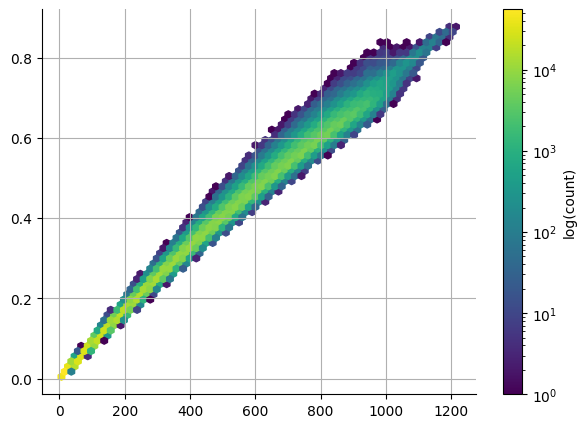

In [6]:
# ===== Cell 3 — Scatter helpers =====
def scatter_with_trend(x, y, mask=None, title="", xlabel="", ylabel="", out=None, gridsize=60):
    m = np.ones_like(x, dtype=bool) if mask is None else mask.astype(bool)
    xv, yv = np.asarray(x)[m], np.asarray(y)[m]
    fig, ax = plt.subplots()
    hb = ax.hexbin(xv, yv, gridsize=gridsize, bins='log')
    cb = fig.colorbar(hb); cb.set_label('log(count)')
    if HAVE_LOWESS and len(xv) > 50:
        order = np.argsort(xv)
        sm = lowess(yv, xv, frac=0.2, return_sorted=True)
        ax.plot(sm[:,0], sm[:,1], lw=2)
    ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    if out:
        Path(out).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show()

# Examples (enable selectively as needed):
if solar_col and ghi_col:
    scatter_with_trend(
        df[ghi_col], df[solar_col], mask=is_day,
        title="Solar vs GHI (daylight)", xlabel="GHI", ylabel="Solar generation",
        out="fig_scatter_solar_vs_GHI.png"
    )

if wind_col and (ws100_col or ws10_col):
    ws_col = ws100_col or ws10_col
    scatter_with_trend(
        df[ws_col], df[wind_col], mask=is_windy,
        title=f"Wind vs {ws_col} (non-calm)", xlabel=ws_col, ylabel="Wind generation",
        out="fig_scatter_wind_vs_ws.png"
    )


In [ ]:
# ===== Cell 4 — Outlier detection =====
def iqr_outliers(s, k=1.5):
    q1, q3 = np.nanpercentile(s, [25, 75])
    iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    return (s < lo) | (s > hi)

def mad_outliers(s, thresh=3.5):
    median = np.nanmedian(s)
    mad = np.nanmedian(np.abs(s - median)) + 1e-9
    z = 0.6745 * (s - median) / mad
    return np.abs(z) > thresh

def robust_bivariate_outliers(x, y, contamination=0.01):
    XY = np.vstack([x, y]).T
    try:
        ee = EllipticEnvelope(contamination=contamination, support_fraction=None, random_state=42)
        ee.fit(XY)
        preds = ee.predict(XY)  # +1 inlier, -1 outlier
        return preds == -1
    except Exception:
        # Fallback: z-score based
        zx = stats.zscore(x, nan_policy='omit'); zy = stats.zscore(y, nan_policy='omit')
        return (np.abs(zx) > 3) | (np.abs(zy) > 3)

def isolation_forest_outliers(X, contamination=0.01):
    mdl = IsolationForest(n_estimators=300, max_samples='auto', contamination=contamination, random_state=42)
    mdl.fit(X)
    return mdl.predict(X) == -1

# Apply univariate outliers on core series (masked to valid contexts)
marks = {}
if solar_col:
    s = df.loc[is_day, solar_col].astype(float)
    marks["solar_iqr"] = pd.Series(False, index=df.index); marks["solar_iqr"][s.index] = iqr_outliers(s.values)
    marks["solar_mad"] = pd.Series(False, index=df.index); marks["solar_mad"][s.index] = mad_outliers(s.values)

if wind_col:
    w = df.loc[is_windy, wind_col].astype(float)
    marks["wind_iqr"] = pd.Series(False, index=df.index); marks["wind_iqr"][w.index] = iqr_outliers(w.values)
    marks["wind_mad"] = pd.Series(False, index=df.index); marks["wind_mad"][w.index] = mad_outliers(w.values)

# Bivariate: (Solar,GHI) daylight; (Wind,WS) non-calm
if solar_col and ghi_col:
    m = is_day & df[ghi_col].notna().values & df[solar_col].notna().values
    bivo = robust_bivariate_outliers(df.loc[m, ghi_col].values, df.loc[m, solar_col].values, contamination=0.01)
    marks["solar_robust2d"] = pd.Series(False, index=df.index); marks["solar_robust2d"][df.loc[m].index] = bivo

if wind_col and (ws100_col or ws10_col):
    ws_col = ws100_col or ws10_col
    m = is_windy & df[ws_col].notna().values & df[wind_col].notna().values
    bivo = robust_bivariate_outliers(df.loc[m, ws_col].values, df.loc[m, wind_col].values, contamination=0.01)
    marks["wind_robust2d"] = pd.Series(False, index=df.index); marks["wind_robust2d"][df.loc[m].index] = bivo

# Multivariate Isolation Forest (example on selected predictors)
feat_cols = [c for c in [ghi_col, dni_col, dhi_col, ws10_col, ws100_col, cc_col, temp_col] if c and c in df.columns]
if len(feat_cols) >= 2:
    X = df[feat_cols].astype(float).fillna(method="ffill").fillna(method="bfill").values
    iso = isolation_forest_outliers(X, contamination=0.01)
    marks["iso_multi"] = pd.Series(iso, index=df.index)

# Summaries
summary = {k: int(v.sum()) for k, v in marks.items()}
print("Outlier counts:", summary)

# Optional: remove outliers for a "clean view" (non-destructive)
df["is_outlier_any"] = False
for k, v in marks.items():
    df["is_outlier_any"] |= v

print("Any-outlier share:", df["is_outlier_any"].mean().round(4))

# Example view: scatter before/after outlier removal
if solar_col and ghi_col:
    scatter_with_trend(df[ghi_col], df[solar_col], mask=is_day,
                       title="Solar vs GHI (all daylight)", xlabel="GHI", ylabel="Solar",
                       out="fig_scatter_solar_vs_GHI_all.png")
    mclean = is_day & (~df["is_outlier_any"].values)
    scatter_with_trend(df[ghi_col], df[solar_col], mask=mclean,
                       title="Solar vs GHI (filtered daylight, outliers removed)", xlabel="GHI", ylabel="Solar",
                       out="fig_scatter_solar_vs_GHI_clean.png")


In [ ]:
# ===== Cell 5 — Correlation matrices =====
def corr_matrix(df_sub, cols, method="pearson"):
    return df_sub[cols].corr(method=method)

def plot_heatmap(corr, title="", out=None, vmin=-1, vmax=1):
    fig, ax = plt.subplots(figsize=(min(0.5+0.4*corr.shape[1], 12), min(0.5+0.4*corr.shape[0], 10)))
    im = ax.imshow(corr.values, vmin=vmin, vmax=vmax)
    ax.set_xticks(range(corr.shape[1])); ax.set_xticklabels(corr.columns, rotation=90)
    ax.set_yticks(range(corr.shape[0])); ax.set_yticklabels(corr.index)
    ax.set_title(title); fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    if out:
        Path(out).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show()

core_cols = [c for c in [solar_col, wind_col, ghi_col, dni_col, dhi_col, ws10_col, ws100_col, cc_col, temp_col] if c]
# Solar-only daylight matrix
if solar_col:
    cols = [c for c in core_cols if c and c in df.columns]
    dm = df.loc[is_day, cols].dropna()
    if len(dm) > 20:
        c_pear = corr_matrix(dm, cols, method="pearson")
        c_spea = corr_matrix(dm, cols, method="spearman")
        plot_heatmap(c_pear, "Correlation (Pearson, daylight)", "fig_corr_daylight_pearson.png")
        plot_heatmap(c_spea, "Correlation (Spearman, daylight)", "fig_corr_daylight_spearman.png")

# Wind-only non-calm matrix
if wind_col:
    cols = [c for c in core_cols if c and c in df.columns]
    dm = df.loc[is_windy, cols].dropna()
    if len(dm) > 20:
        c_pear = corr_matrix(dm, cols, method="pearson")
        c_spea = corr_matrix(dm, cols, method="spearman")
        plot_heatmap(c_pear, "Correlation (Pearson, non-calm)", "fig_corr_wind_pearson.png")
        plot_heatmap(c_spea, "Correlation (Spearman, non-calm)", "fig_corr_wind_spearman.png")


In [ ]:
# ===== Cell 6 — QQ plots =====
def qqplot(series, title="", out=None):
    fig, ax = plt.subplots()
    stats.probplot(series.dropna(), dist="norm", plot=ax)
    ax.set_title(title)
    if out:
        Path(out).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show()

if solar_col:
    qqplot(df.loc[is_day, solar_col].astype(float), "QQ: Solar (daylight)", "fig_qq_solar_daylight.png")
if wind_col:
    qqplot(df.loc[is_windy, wind_col].astype(float), "QQ: Wind (non-calm)", "fig_qq_wind_nocalm.png")
if ghi_col:
    qqplot(df.loc[is_day, ghi_col].astype(float), "QQ: GHI (daylight)", "fig_qq_ghi_daylight.png")


In [ ]:
# ===== Cell 7 — Sample-size & power =====
from math import sqrt
from scipy.stats import norm

def n_for_mean(Z=1.96, sigma=10.0, E=2.0):
    """For descriptive CI on a mean: n = (Z*sigma/E)^2"""
    return (Z * sigma / E) ** 2

def n_for_paired(delta_abs, sd_diff, alpha=0.05, power=0.80, two_sided=True):
    """Required n (paired) to detect absolute improvement delta_abs with given sd_diff."""
    z_alpha = norm.ppf(1 - alpha/2) if two_sided else norm.ppf(1 - alpha)
    z_beta  = norm.ppf(power)
    return ((z_alpha + z_beta) * sd_diff / delta_abs) ** 2

def achieved_power_paired(n, delta_abs, sd_diff, alpha=0.05, two_sided=True):
    """Power given sample size n for paired difference."""
    z_alpha = norm.ppf(1 - alpha/2) if two_sided else norm.ppf(1 - alpha)
    z_term  = (sqrt(n) * delta_abs / sd_diff) - z_alpha
    return float(norm.cdf(z_term))

# --- Simple σ estimator from a baseline error series (e.g., persistence MAE) ---
def persistence_forecast(series):
    """One-step persistence (yhat_t = y_{t-1}). Series must be time-ordered."""
    y = series.astype(float).values
    yhat = np.r_[np.nan, y[:-1]]
    return pd.Series(yhat, index=series.index)

def bootstrap_sigma_of_metric(y_true, y_pred, metric="mae", B=500, block=24, random_state=42):
    """Block bootstrap to estimate sigma of a metric (MAE or RMSE) under autocorrelation."""
    rng = np.random.default_rng(random_state)
    n = len(y_true); idx = np.arange(n)
    def metric_fn(a, b):
        e = np.abs(a - b) if metric.lower()=="mae" else (a - b)**2
        return np.nanmean(e) if metric.lower()=="mae" else np.sqrt(np.nanmean(e))
    vals = []
    for _ in range(B):
        start = rng.integers(0, max(1, n - block))
        take = np.concatenate([np.arange(start + i*block, min(n, start + (i+1)*block)) for i in range(max(1, n//block))])
        take = take[take < n]
        vals.append(metric_fn(y_true[take], y_pred[take]))
    return np.std(vals, ddof=1)

# ---- Example usage (edit metric/targets as needed) ----
# Use solar daylight hours and a persistence baseline to illustrate σ for MAE:
if solar_col:
    m = is_day & df[solar_col].notna().values
    y = df.loc[m, solar_col].astype(float)
    yhat = persistence_forecast(y).fillna(method="bfill")  # simple baseline
    sig_mae = bootstrap_sigma_of_metric(y.values, yhat.values, metric="mae", B=400, block=24)
    baseline_mae = np.mean(np.abs(y.values - yhat.values))
    print(f"Solar (daylight) baseline MAE ~ {baseline_mae:.3f}, sigma(MAE)~{sig_mae:.3f}")

    # RQ1-style: required n to estimate mean MAE with ±E margin (units)
    n_req_mean = n_for_mean(Z=1.96, sigma=sig_mae, E=baseline_mae*0.10)  # e.g., ±10% of baseline MAE
    print(f"n required (±10% MAE margin at 95%): ~{math.ceil(n_req_mean)} hourly points")

    # RQ2-style (paired): detect 5% absolute improvement in MAE
    delta_abs = baseline_mae * 0.05
    # Approximate sd_diff by sigma(MAE). For exact paired Δ, pass SD of (err_baseline - err_model).
    n_req_paired = n_for_paired(delta_abs=delta_abs, sd_diff=sig_mae, alpha=0.05, power=0.80, two_sided=True)
    print(f"Paired n required for 5% MAE improvement (80% power): ~{math.ceil(n_req_paired)}")

# To compute achieved power later, once model errors are available:
# power = achieved_power_paired(n=current_n, delta_abs=delta_abs, sd_diff=sig_of_paired_diff, alpha=0.05)
# print("Achieved power:", round(power, 3))


In [ ]:
# ===== Cell 8 — Figure collection (optional) =====
# This cell simply documents where figures were saved by previous cells.
# If needed, move files into a single folder for the report.

TARGET_DIR = Path("/content/drive/MyDrive/Colab Notebooks/out")
TARGET_DIR.mkdir(parents=True, exist_ok=True)
for f in Path(".").glob("fig_*.png"):
    f.rename(TARGET_DIR / f.name)

print("Collected figures:", list(TARGET_DIR.glob("*.png")))
